# Typology for doubles

1. Identify 2-artifact clusters (pairs of contiguous artifacts); make sure that the union has no interior
2. For each cluster, classify the inside edge as C or nonC (`drop_interline`: bool)
3. Visualize and test if it works

- number of nodes
- number of continuity groups
- filter non-planarity artifacts
- CES counts
- prime detection
- crosses detection
- touches detecion

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from scipy import sparse
import folium
import folium.plugins as plugins
import shapely

from core import algorithms, utils
from core.geometry import voronoi_skeleton

Specify case metadata

In [2]:
case = "Liège"

Read road data

In [3]:
roads = utils.read_original(case)

Remove duplicated roads

In [4]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Identify artifacts

In [5]:
artifacts = momepy.FaceArtifacts(roads).face_artifacts.set_crs(roads.crs)
artifacts["id"] = artifacts.index

Remove edges fully within the artifact (dangles).

In [6]:
a_idx, _ = roads.sindex.query(artifacts.geometry, predicate="contains")
artifacts = artifacts.drop(artifacts.index[a_idx])

Filter doubles

In [7]:
rook = graph.Graph.build_contiguity(artifacts, rook=True)
artifacts["comp"] = rook.component_labels
counts = artifacts["comp"].value_counts()
artifacts = artifacts.loc[artifacts["comp"].isin(counts[counts == 2].index)]

In [8]:
artifacts

,geometry,face_artifact_index,id,comp
10,"POLYGON ((685360.558 5609766.62, 685359.515 56...",7.000197,10,3
11,"POLYGON ((682082.999 5609910.253, 682075.805 5...",5.472530,11,4
19,"POLYGON ((679864.921 5612652.577, 679838.132 5...",5.477689,19,6
123,"POLYGON ((665538.217 5608558.621, 665611.953 5...",5.875323,123,22
124,"POLYGON ((665611.953 5608515.688, 665538.217 5...",5.419501,124,22
...,...,...,...,...
6689,"POLYGON ((688772.028 5621515.847, 688780.77 56...",3.963123,6689,1139
6750,"POLYGON ((690331.109 5616336.72, 690327.177 56...",5.915152,6750,1152
6752,"POLYGON ((690326.665 5616357.732, 690330.555 5...",3.506460,6752,1152
6759,"POLYGON ((690618.224 5615362.332, 690613.569 5...",5.602549,6759,584


Optionally define a subset of data.

In [9]:
data_sample = artifacts

In [10]:
def _classify_interline(mycluster, artifacts, roads):
    # get the cluster geometry
    cluster_geom = artifacts[artifacts.comp == mycluster].union_all()

    # find the road segment that is contained within the cluster geometry
    road_contained = roads.sindex.query(cluster_geom, predicate="contains")

    # make sure we have uniquely identified the road segment
    if len(road_contained) == 1:

        # return the ID of the road segment (to potentially drop later)
        # and coins_end True/False
        return pd.Series([road_contained[0], roads.loc[road_contained]["coins_end"].values[0]])
    else:
        return pd.Series([None, None])

In [11]:
def simplify_pairs(artifacts, roads, distance=2):
    # Get nodes from the network.
    nodes = momepy.nx_to_gdf(momepy.node_degree(momepy.gdf_to_nx(roads)), lines=False)

    # Link nodes to artifacts
    node_idx, artifact_idx = artifacts.sindex.query(
        nodes.buffer(0.1), predicate="intersects"
    )
    intersects = sparse.coo_array(
        ([True] * len(node_idx), (node_idx, artifact_idx)),
        shape=(len(nodes), len(artifacts)),
        dtype=np.bool_,
    )

    # Compute number of nodes per artifact
    artifacts["node_count"] = intersects.sum(axis=0)

    # Compute number of stroke groups per artifact
    roads, _ = algorithms.common.continuity(roads)
    strokes, c_, e_, s_ = algorithms.common.get_stroke_info(artifacts, roads)

    artifacts["stroke_count"] = strokes
    artifacts["C"] = c_
    artifacts["E"] = e_
    artifacts["S"] = s_

    # LOOP 0 - drop and treat as a whole
    # TODO: include half on non-dropping

    # Filer artifacts caused by non-planar intersections.
    artifacts["non_planar"] = artifacts["stroke_count"] > artifacts["node_count"]
    a_idx, _ = roads.sindex.query(artifacts.geometry.boundary, predicate="overlaps")
    artifacts.iloc[np.unique(a_idx), -1] = True

    # Remove (for now) the clusters that contain at least one non-planar component
    # (TODO: we will deal with them later, ...?)
    # non_planar_cluster: number of non-planar artifacts per cluster
    artifacts["non_planar_cluster"] = artifacts.apply(
        lambda x: sum(artifacts.loc[artifacts["comp"] == x.comp]["non_planar"]), axis=1
    )
    # dealing with the non-planar later!
    artifacts = artifacts[artifacts.non_planar_cluster == 0]

    apply_r = artifacts.comp.apply(
        lambda x: _classify_interline(x, artifacts, roads)
    )
    artifacts["inter_road"] = apply_r[0]
    artifacts["inter_coins_end"] = apply_r[1]
    artifacts["drop_interline"] = artifacts["inter_coins_end"]

    # if one of the 2 artifacts is of type 0C0EnS, then no matter whether
    # inter_coins_end is True or False! it will always be S
    comps_with_s = list(artifacts[(artifacts.C == 0) & (artifacts.E == 0)].comp)
    artifacts.loc[artifacts["comp"].isin(comps_with_s), "drop_interline"] = True

    to_drop = (
        artifacts.drop_duplicates("comp").query("drop_interline == True").inter_road
    )
    merged_pairs = artifacts.query("drop_interline == True").dissolve("comp")

    roads_cleaned = roads.drop(to_drop.dropna().values)

    loop_1 = algorithms.simplify.simplify_singletons(
        merged_pairs, roads_cleaned, distance=distance
    )

    # LOOP_2
    # TODO: second half
    return loop_1

In [12]:
new_roads = simplify_pairs(data_sample, roads)

/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is tr

In [13]:
new_roads

0        LINESTRING (687053.642 5615820.989, 687059.393...
1        LINESTRING (687051.723 5615826.386, 687053.642...
2        LINESTRING (677429.096 5613705.29, 677400.757 ...
3        LINESTRING (680017.116 5611745.281, 680093.093...
4        LINESTRING (675509.451 5613807.976, 675523.116...
                               ...                        
28118    LINESTRING (694471.883 5612766.839, 694473.954...
28119    LINESTRING (693247.71 5613359.845, 693333.949 ...
28120    LINESTRING (694599.342 5612818.225, 694602.77 ...
28121    LINESTRING (694681.706 5612783.026, 694740.918...
28122    LINESTRING (694779.72 5612807.35, 694853.904 5...
Length: 28123, dtype: geometry

10


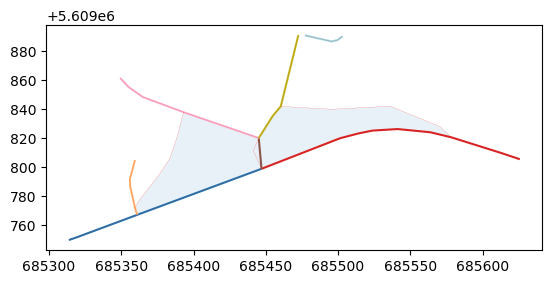

11


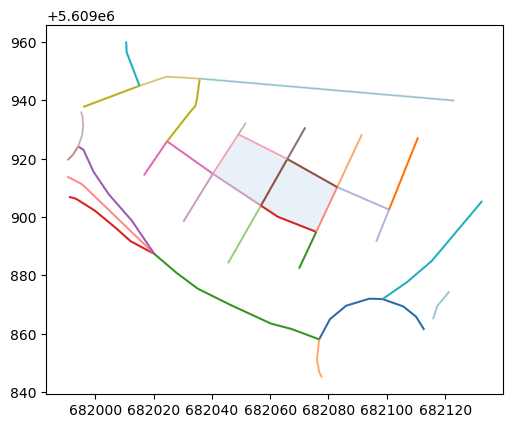

19


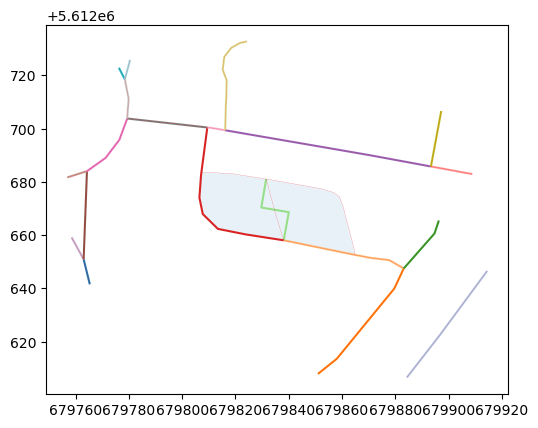

123


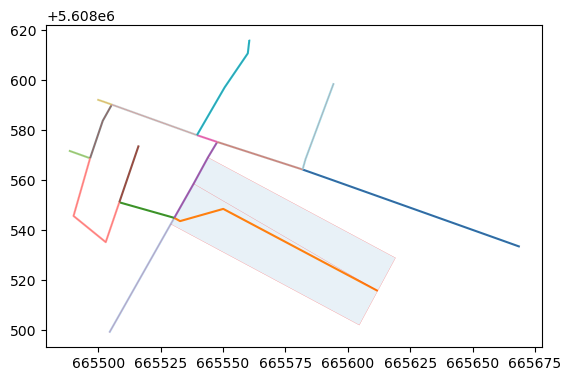

124


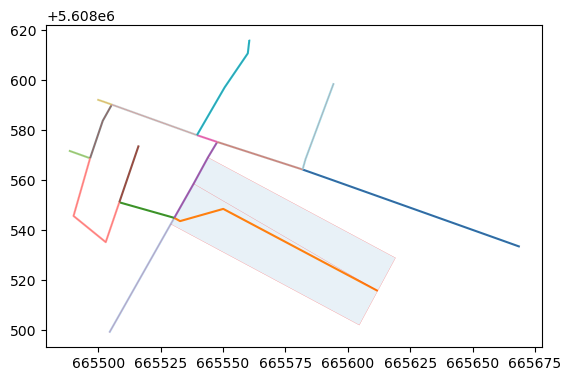

151


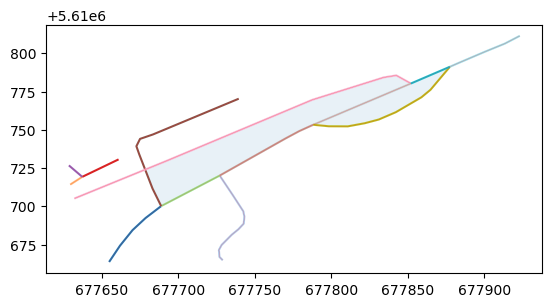

153


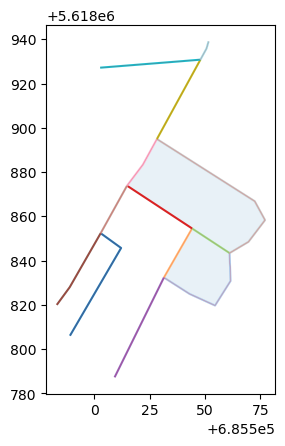

155


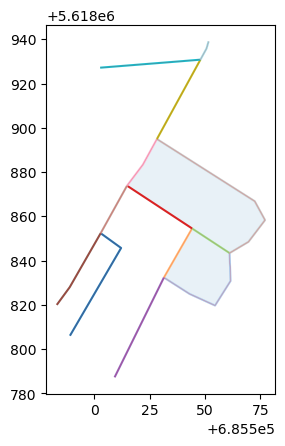

206


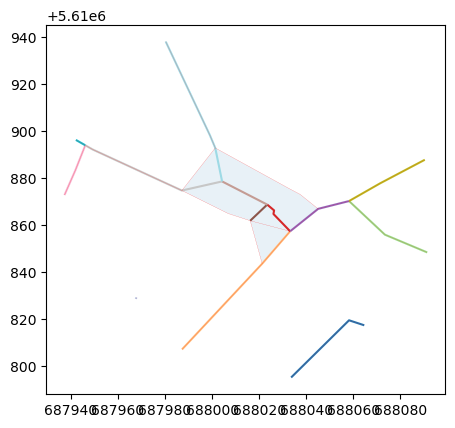

211


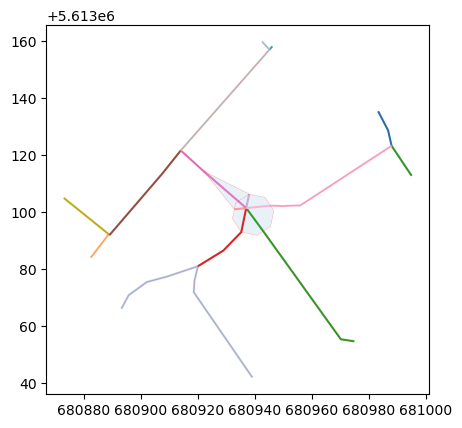

In [22]:
for artifact in data_sample.iloc[:10].itertuples():
    print(artifact.Index)

    # plot the results for visual verification
    couple = artifacts[artifacts.comp == artifact.comp]
    geom = couple.union_all()
    ax = new_roads.clip(geom.buffer(50)).plot(zorder=2, cmap="tab20")
    couple.plot(ax=ax, alpha=.1)
    roads.clip(geom.buffer(50)).plot(
        color="red",
        ax=ax,
        # categorical=True,
        # legend=True,
        linewidth=0.1,
    )
    plt.show()

In [18]:
artifact.comp

3